In [1]:
import pandas
import pathlib
from matplotlib import pyplot as plt
from config import datadir

import scipy.optimize
import numpy
from tbcontrol.responses import fopdt, sopdt

In [2]:
excel_directory = pandas.read_excel(datadir/'Data Description.xlsx', parse_dates=True, index_col='Start Date') #Loads complete excel directory used to organise datasets
excel_directory

,End Date,Equipment,Type,Purpose,Filename,Run,Description
Start Date,,,,,,,
2019-12-06,2019-12-11,pH Probe,Raw,Test Drift on pH probe,20191206 pH Drift 1.txt,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Raw,Test Drift on pH probe,20191211 pH Drift 2.txt,2,"long run of pH probe drift, performed inside t..."
2019-12-17,2019-12-23,pH Probe,Raw,Test Drift on pH probe,20191217 pH Drift 3.txt,3,"long run of pH probe Drift, circulating ph7 bu..."
2020-01-16,2020-01-16,pH Probe,Raw,Step Test,20200116 pH Step 3.txt,3,pH stepped outside of rig
2020-01-14,2020-01-14,pH Probe,Raw,Step Test,20200114 pH Step 1.broken,1,"pH stepped outside of rig. Probe Broke, Dump run"
2020-01-15,2020-01-15,pH Probe,Raw,Step Test,20200115 pH Step 2.txt,2,pH stepped outside of rig
2020-01-01,2020-01-01,Pumps,Calibration,Calibration,Pump Calibration.xlsx,1,Calibration data for all pumps
2019-12-06,2019-12-11,pH Probe,Drift,Test Drift on pH probe,20191206 pH Drift 1.csv,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Drift,Test Drift on pH probe,20191211 pH Drift 2.csv,2,"long run of pH probe drift, performed inside t..."


In [3]:
steps = excel_directory[(excel_directory['Type']=='Step Test')]    # Creates a new directory of only the raw data files to be cleaned 
                                                            # Use '&' for multiple conditions

In [4]:
external_steps = pandas.read_csv(datadir /'20200115 pH Step 2.csv')
external_steps

,DateTime,Temp,pH
0,2020-01-15 11:59:11,293.801689,7.074204
1,2020-01-15 11:59:12,293.802309,7.074330
2,2020-01-15 11:59:13,293.802142,7.075654
3,2020-01-15 11:59:14,293.801788,7.079847
4,2020-01-15 11:59:15,293.802407,7.082653
...,...,...,...
90683,2020-01-16 13:10:34,293.048022,13.038681
90684,2020-01-16 13:10:35,293.048218,13.038362
90685,2020-01-16 13:10:36,293.048454,13.038238
90686,2020-01-16 13:10:37,293.047766,13.038757


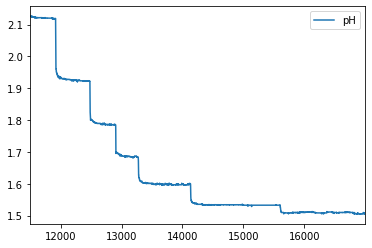

In [5]:
external_steps[11500:17000].plot(y='pH')

[0.004233480597973648, 6.437151955432731, 116.25804619257529, 0.007597795707585578]
[0.004268643963811211, 4.420610538927211, 230.6191587193279, 0.01192970419295911]
[0.004060767755792508, 2.1449709723912536, 154.6087954935193, 0.016390985230372877]
[0.004502287923417629, 12.050040959063399, 222.91662679363174, 0.020657136461181082]
[0.003970881100418581, 9.088948686177154, 531.776519305175, 0.025243113959621706]
[0.0016241795615382542, 8.268793056758758, 605.947650149439, 0.02935394045524108]


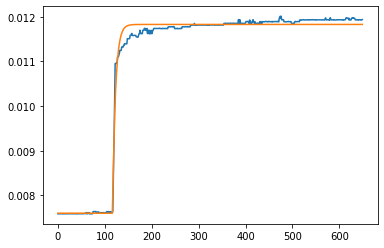

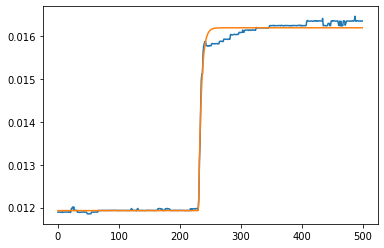

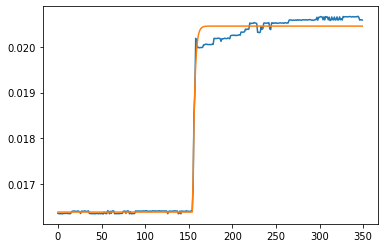

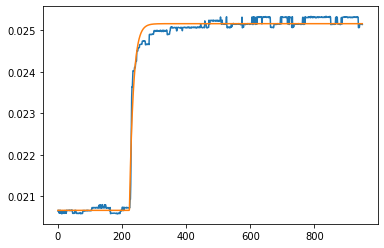

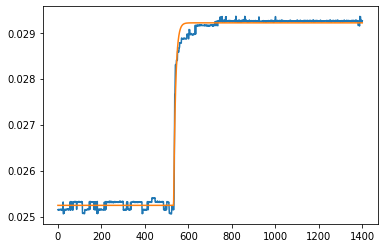

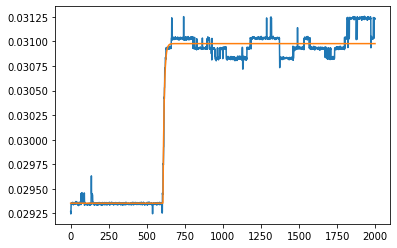

In [6]:
spans=[[11800,12450],[12250,12750],[12750,13100],[13050,14000],[13600,15000],[15000,17000]]


ph_list = []
poh_list = []
ph_delogged = []
poh_delogged = []
time_list = []

K_list, tau_list, theta_list, y0_list = [], [], [], []

for span in spans:
    lower = span[0]
    upper = span[1]
    
    time_set = numpy.array(external_steps['DateTime'][lower:upper].index.tolist())-lower
    ph_set = numpy.array(external_steps['pH'][lower:upper].values)
    poh_set = 14 - ph_set
    ph_delogged_set = 10**(-ph_set)
    poh_delogged_set = 10**(-poh_set)
    
#     print (poh_set)
    
    time_list.append(time_set)
    
    ph_list.append(ph_set)
    poh_list.append(poh_set)
    
    ph_delogged.append(ph_delogged_set)
    poh_delogged.append(poh_delogged_set)
    
    [K, tau, theta, y0], _ = scipy.optimize.curve_fit(fopdt, time_set, 
                                                      ph_delogged_set, [0.004, 4, 200, 50])
    
    K_list.append(K)
    tau_list.append(tau)
    theta_list.append(theta)
    y0_list.append(y0)
    
    print([K, tau, theta, y0])
    
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(fopdt(time_set, K, tau, theta, y0))


In [7]:
K = numpy.average(K_list[:-1])
tau = numpy.average(tau_list[:-1])
K, tau

(0.004207212268282716, 6.82834462239835)

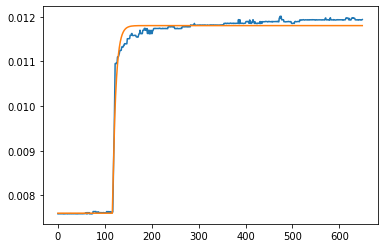

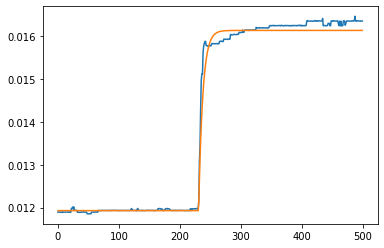

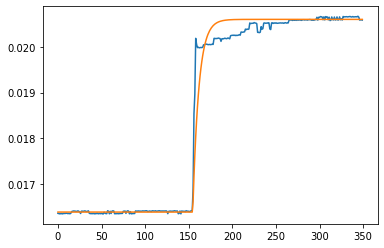

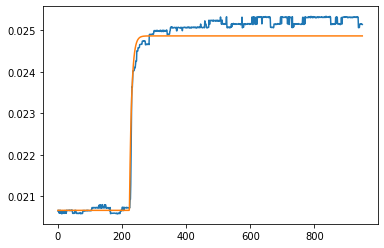

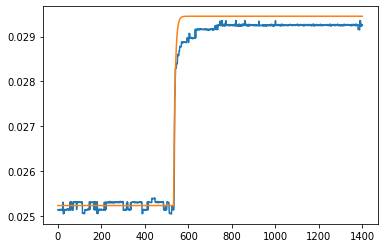

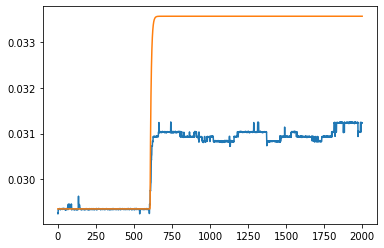

In [8]:
for time_set, ph_delogged_set, theta, y0 in zip(time_list, ph_delogged, theta_list, y0_list):
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(fopdt(time_set, K, tau, theta, y0))